In [2]:
import numpy as np
from scipy.sparse import diags


def func(x):
    '''
    calcola la funzione obiettivo del Banded Tridiagonal Problem
    
    F(x) = sum(i * [(1 - cos(x_i)) + sin(x_{i-1}) - sin(x_{i+1})])
    
    x_0 = x_{n+1} = 0,
    bar(x)_i = 1, i >= 1
    Si puo semplificare algebricamente e avere:
    F(x) = sum(i * (1-cos(x_i))) + 2 * sum(sin(x_k)) - (n-1) * sin(x_n)
    '''
    x = np.asarray(x)
    n = len(x)
    
    # 1. Parte del Coseno: Dipende dall'indice 'i'
    # Formula: sum( i * (1 - cos(x_i)) )
    i_vec = np.arange(1, n + 1)
    cos_part = np.sum(i_vec * (1 - np.cos(x)))
    
    # 2. Parte dei Seni: Semplificata algebricamente
    # Formula: 2 * sum(sin(x_1...x_{n-1})) - (n-1)*sin(x_n)
    # Nota: x[:-1] prende tutti tranne l'ultimo
    sin_sum_inner = 2 * np.sum(np.sin(x[:-1])) 
    sin_last_term = - (n - 1) * np.sin(x[-1])
    
    sin_part = sin_sum_inner + sin_last_term
    
    F_x = cos_part + sin_part
    return F_x
    
    
def gradient(x, h=1e-5):
    """
    Calcola il gradiente usando Differenze Finite Centrate 
    sulla versione SEMPLIFICATA algebricamente della funzione.
    Non richiede padding né accesso ai vicini.
    """
    x = np.asarray(x)
    n = len(x)
    
    # Indici [1, 2, ..., n] per il coefficiente del coseno
    ids = np.arange(1, n + 1)
    
    def get_local_contributions(val):
        """
        Calcola il vettore dei contributi locali per un dato vettore val.
        Restituisce un array di dimensione n.
        """
        # 1. Parte Coseno: k * (1 - cos(x_k))
        cos_part = ids * (1 - np.cos(val))
        
        # 2. Parte Seno: 
        #    2 * sin(x_k) per tutti
        #    -(n-1) * sin(x_n) per l'ultimo
        # 1. Creiamo un array vuoto della stessa forma di val
        sin_part = np.empty_like(val)
        # 2. Riempiamo tutti tranne l'ultimo (da 0 a n-1)
        # Calcola il seno solo per gli elementi necessari
        sin_part[:-1] = 2 * np.sin(val[:-1])
        # 3. Riempiamo l'ultimo elemento specificamente
        sin_part[-1] = -(n - 1) * np.sin(val[-1])
        
        return cos_part + sin_part
    # Calcolo Vettorizzato
    # Calcoliamo i termini perturbati (x+h) e (x-h) per tutto il vettore insieme
    terms_plus = get_local_contributions(x + h)
    terms_minus = get_local_contributions(x - h)
    
    # Differenza Centrata
    # Gradiente = (f(x+h) - f(x-h)) / 2h
    grad = (terms_plus - terms_minus) / (2 * h)
    
    return grad


def hessian(x, h=1e-5):
    x = np.asarray(x)
    n = len(x)
    ids = np.arange(1, n + 1)
    
    # Coefficienti per la parte seno
    alpha = np.full(n, 2.0)
    alpha[-1] = -(n - 1)
    
    def get_local_val(val):
        # Calcola il valore "locale" della funzione per ogni componente
        # F_k = k*(1 - cos(x)) + alpha*sin(x)
        term_cos = ids * (1 - np.cos(val))
        term_sin = alpha * np.sin(val)
        return term_cos + term_sin
    # 1. Calcoliamo f(x), f(x+h), f(x-h)
    val_curr = get_local_val(x)
    val_plus = get_local_val(x + h)
    val_minus = get_local_val(x - h)
    
    # 2. Formula Differenze Finite per derivata seconda
    # (f(x+h) - 2f(x) + f(x-h)) / h^2
    h_diag = (val_plus - 2 * val_curr + val_minus) / (h ** 2)
    
    return diags(h_diag) #, 0, shape= (n,n))

In [3]:
import numdifftools as nd
import numpy as np

n = 100
x0 = np.ones(n)




# 2. Crea gli oggetti Gradient e Hessian
grad_tool = nd.Gradient(func)
hess_tool = nd.Hessian(func)

print(func(x0))

print("Gradiente con numdifftools:", grad_tool(x0))
print("Hessiana con numdifftools:\n", hess_tool(x0))

print("Gradiente autoimplementato:", gradient(x0))
print("Hessiana autoimplementata: \n", hessian(x0).toarray())

2404.7789828618756
Gradiente con numdifftools: [ 1.9220756   2.76354658  3.60501757  4.44648855  5.28795954  6.12943052
  6.97090151  7.81237249  8.65384347  9.49531446 10.33678544 11.17825643
 12.01972741 12.8611984  13.70266938 14.54414037 15.38561135 16.22708234
 17.06855332 17.91002431 18.75149529 19.59296628 20.43443726 21.27590825
 22.11737923 22.95885022 23.8003212  24.64179219 25.48326317 26.32473416
 27.16620514 28.00767613 28.84914711 29.6906181  30.53208908 31.37356006
 32.21503105 33.05650203 33.89797302 34.739444   35.58091499 36.42238597
 37.26385696 38.10532794 38.94679893 39.78826991 40.6297409  41.47121188
 42.31268287 43.15415385 43.99562484 44.83709582 45.67856681 46.52003779
 47.36150878 48.20297976 49.04445075 49.88592173 50.72739272 51.5688637
 52.41033469 53.25180567 54.09327665 54.93474764 55.77621862 56.61768961
 57.45916059 58.30063158 59.14210256 59.98357355 60.82504453 61.66651552
 62.5079865  63.34945749 64.19092847 65.03239946 65.87387044 66.71534143
 67.5

In [4]:
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spla
from root.utils import backtracking_line_search # Rimosso il punto (.) prima di utils se esegui localmente

class NewtonMethods:
    
    @staticmethod
    def modified_newton_banded(x0, f, gradf, hessf, alpha0=1.0, kmax=100, tolgrad=1e-5, c1=1e-4, rho=0.5, btmax=20):
        xk = x0.copy()
        n = len(x0)
        k = 0
        history = []
        
        grad_xk = gradf(xk)
        gradfk_norm = np.linalg.norm(grad_xk)
        fx = f(xk)
        
        # Salviamo lo stato iniziale
        history.append({'k': k, 'x': xk.copy(), 'fx': fx, 'gnorm': gradfk_norm})
        
        print(f"START: Newton Modificato con Cholesky a BANDA. N={n}")
        
        while k < kmax and gradfk_norm > tolgrad:
            # 1. Calcolo Hessiana Sparsa
            H_sparse = hessf(xk)
            
            # 2. Conversione in formato "Banded"
            main_diag = H_sparse.diagonal(0)
            low1_diag = np.append(H_sparse.diagonal(-1), 0) 
            low2_diag = np.append(H_sparse.diagonal(-2), [0, 0])
            
            ab_original = np.vstack([main_diag, low1_diag, low2_diag])
            
            # --- NEWTON MODIFICATO (Tau adjustment) ---
            tau = 0
            beta = 1e-3
            
            while True:
                ab = ab_original.copy()
                if tau > 0:
                    ab[0, :] += tau
                
                try:
                    c = spla.cholesky_banded(ab, lower=True, overwrite_ab=False)
                    pk = spla.cho_solve_banded((c, True), -grad_xk)
                    if tau > 0:
                        print(f"  > Matrice corretta con tau={tau:.4e}")
                    break 

                except np.linalg.LinAlgError:
                    if tau == 0:
                        tau = beta
                    else:
                        tau = 2 * tau
                    
                    if tau > 1e10:
                        pk = -grad_xk
                        print("  ! Fallback al gradiente")
                        break

            # 3. Backtracking
            alpha_k = backtracking_line_search(f, gradf, xk, pk, alpha0, rho, c1, btmax)
            
            xk = xk + alpha_k * pk
            
            # Aggiornamento
            grad_xk = gradf(xk)
            gradfk_norm = np.linalg.norm(grad_xk)
            fx = f(xk)
            
            k += 1
            
            # --- MODIFICA QUI: Salviamo xk.copy() ---
            history.append({'k': k, 'x': xk.copy(), 'fx': fx, 'gnorm': gradfk_norm})
            
            if k % 10 == 0:
                print(f"Iter: {k} | f(x): {fx:.4e} | ||g||: {gradfk_norm:.4e}")

        return xk, fx, gradfk_norm, k, history

    @staticmethod
    def truncated_newton(x0, f, gradf, hessf, alpha0, kmax, tolgrad, c1, rho, btmax):
        xk = x0.copy()
        n = len(x0)
        history = []
        
        # Salviamo lo stato iniziale
        fx = f(xk)
        gradk = gradf(xk)
        grad_norm = npl.norm(gradk)
        history.append({'k': 0, 'x': xk.copy(), 'fx': fx, 'gnorm': grad_norm})

        for k in range(kmax):
            # Nota: gradk e grad_norm sono già calcolati o aggiornati a fine loop precedente
            if grad_norm < tolgrad:
                print(f"Convergenza raggiunta all'iterazione {k}")
                return xk, fx, grad_norm, k, history
            
            B = hessf(xk)
            eta_k = min(0.5, np.sqrt(grad_norm))

            z = np.zeros(n)
            r = -gradk - B @ z
            d = r.copy()
            
            cg_iter = 0
            max_cg_iter = n * 2 # Safety limit
            pk = None

            while cg_iter < max_cg_iter:
                Bd = B @ d
                dBd = d.T @ Bd

                if dBd > 0:
                    alpha_j = (r.T @ r) / dBd
                    z_next = z + alpha_j * d
                    r_next = r - alpha_j * Bd
                
                    beta_cg = (r_next.T @ r_next) / (r.T @ r)
                    d = r_next + beta_cg * d
                else:
                    if cg_iter == 0:
                        pk = -gradk
                    else:
                        pk = z
                    break
                
                z = z_next
                r = r_next
                cg_iter += 1

                if npl.norm(r_next) <= eta_k * grad_norm:
                    pk = z_next
                    break

            if pk is None:
                pk = z

            alpha_k = backtracking_line_search(f, gradf, xk, pk, alpha0, rho, c1, btmax)

            xk = xk + alpha_k * pk
            
            # Ricalcolo valori per il prossimo step e per la history
            fx = f(xk)
            gradk = gradf(xk)
            grad_norm = npl.norm(gradk)
            
            # --- MODIFICA QUI: Salviamo xk.copy() ---
            history.append({'k': k+1, 'x': xk.copy(), 'fx': fx, 'gnorm': grad_norm})

        return xk, fx, grad_norm, k, history
    
    @staticmethod
    def truncated_newton_preconditioned(x0, f, gradf, hessf, alpha0, kmax, tolgrad, c1, rho, btmax):
        xk = x0.copy()
        n = len(x0)
        history = []

        # Salvataggio stato iniziale
        fx = f(xk)
        gradk = gradf(xk)
        grad_norm = npl.norm(gradk)
        history.append({'k': 0, 'x': xk.copy(), 'fx': fx, 'gnorm': grad_norm})

        print(f"START: Truncated Newton Preconditioned (N={n})")

        for k in range(kmax):
            if grad_norm < tolgrad:
                print(f"Convergenza raggiunta all'iterazione {k}")
                return xk, fx, grad_norm, k, history
            
            # 1. Calcolo Hessiana (o LinearOperator)
            B = hessf(xk)
            
            # [PRECONDITIONING] 2. Estrazione della diagonale per Jacobi
            # Se B è una matrice sparsa o densa, estraiamo la diagonale.
            # Aggiungiamo un epsilon per evitare divisioni per zero.
            if hasattr(B, 'diagonal'): # Se è matrice numpy o scipy sparse
                diag_B = B.diagonal()
            else:
                # Fallback se B è un LinearOperator senza accesso diretto (raro qui)
                diag_B = np.ones(n) 
            
            # Invertiamo la diagonale (M^-1)
            # 1e-6 serve per stabilità se la curvatura è quasi zero
            M_inv = 1.0 / (np.abs(diag_B) + 1e-6) 

            # Parametri per il ciclo CG
            eta_k = min(0.5, np.sqrt(grad_norm)) * grad_norm # Forzatura più stretta
            
            # --- INIZIO PRECONDITIONED CONJUGATE GRADIENT (PCG) ---
            z = np.zeros(n)          
            r = -gradk - B @ z       # Residuo
            
            # [PRECONDITIONING] Applicazione precondizionatore
            y = M_inv * r            # y = M^-1 * r
            p = y.copy()             # Direzione di ricerca iniziale (p invece di d)
            
            r_dot_y = r.T @ y        # Prodotto scalare precondizionato
            
            cg_iter = 0
            max_cg_iter = n * 2 # Safety limit
            
            step_found = False

            while cg_iter < max_cg_iter:
                Bp = B @ p
                pBp = p.T @ Bp

                if pBp > 0:
                    alpha_cg = r_dot_y / pBp
                    z_next = z + alpha_cg * p
                    r_next = r - alpha_cg * Bp
                    
                    # Check convergenza del CG
                    if npl.norm(r_next) <= eta_k:
                        z = z_next
                        step_found = True
                        break
                    
                    # [PRECONDITIONING] Passo successivo
                    y_next = M_inv * r_next
                    r_next_dot_y_next = r_next.T @ y_next
                    
                    beta_cg = r_next_dot_y_next / r_dot_y
                    p = y_next + beta_cg * p
                    
                    # Aggiornamento variabili loop
                    z = z_next
                    r = r_next
                    y = y_next
                    r_dot_y = r_next_dot_y_next
                    cg_iter += 1
                else:
                    # Curvatura negativa incontrata
                    if cg_iter == 0:
                        # Se capita subito, usiamo il gradiente precondizionato o steepest descent
                        z = y # Fallback alla direzione del precondizionatore
                    # Se capita dopo, usiamo la z corrente che è una buona direzione di discesa
                    step_found = True
                    break
            
            pk = z
            # --- FINE PCG ---

            # Backtracking (Line Search)
            alpha_k = backtracking_line_search(f, gradf, xk, pk, alpha0, rho, c1, btmax)
            
            xk = xk + alpha_k * pk
            
            # Update valori
            fx = f(xk)
            gradk = gradf(xk)
            grad_norm = npl.norm(gradk)
            
            history.append({'k': k+1, 'x': xk.copy(), 'fx': fx, 'gnorm': grad_norm})
            
            # Debug ogni tanto
            if (k+1) % 10 == 0:
                print(f"Iter {k+1}: ||g|| = {grad_norm:.2e}, CG iters = {cg_iter}")

        return xk, fx, grad_norm, k, history

Problem Size: 2
Initial Cost a [1.2372636  0.43722849]: 2.3271e+00

START: Truncated Newton (N=2)...
0
0
0
0
Convergenza raggiunta all'iterazione 4
DONE. Steps: 4, Final f(x): -1.4721e+00, Time: 0.0008 s
Preparazione grafico 3D...


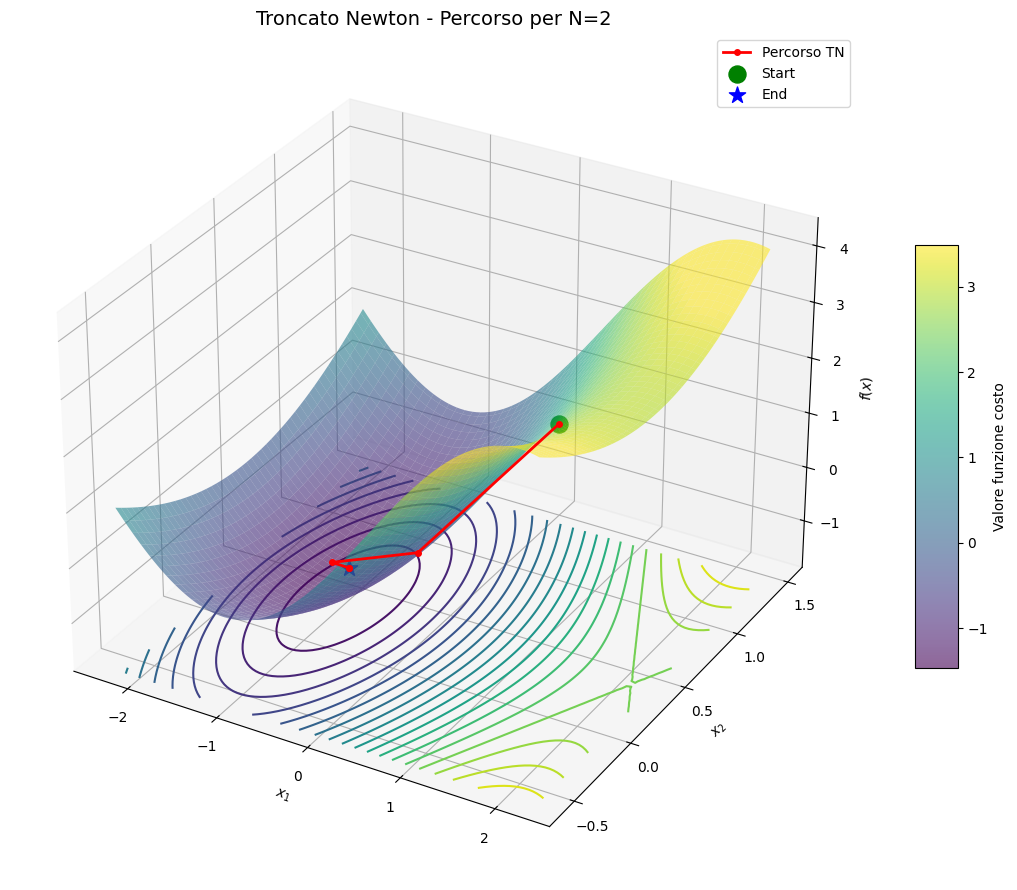

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

# Importa i tuoi moduli
from root.banded_trig import BandedTrigonometric
# from banded_trig import BandedTrigonometric # Puoi usare questa se preferisci
#from root.methods import NewtonMethods

# ==========================================
# CONFIGURAZIONE PER N=2
# ==========================================
N = 2
TOL = 1e-8
K_MAX = 200
np.random.seed(358616)
# Punto iniziale per N=2 (Broyden standard spesso parte da -1)
x0 = np.random.uniform(0,2,N)
# x0 = np.array([-0.5, 1.5]) # Prova punti diversi per vedere percorsi diversi!

problem_class = BandedTrigonometric # O BandedTrigonometric
func_to_optimize = problem_class.func
grad_to_optimize = problem_class.gradient
hess_to_optimize = problem_class.hessian # O hessian normale se N=2

print(f"Problem Size: {N}")
print(f"Initial Cost a {x0}: {func_to_optimize(x0):.4e}")

# ==========================================
# ESECUZIONE TRUNCATED NEWTON
# ==========================================
print("\n" + "="*30)
print(f"START: Truncated Newton (N={N})...")

start_time = time.perf_counter()

# NOTA: Assumo che methods.py salvi 'x' e 'fx' in ogni passo dello storico.
# Se il tuo codice salva solo le norme, questo script darà errore.
xk_tn, fxk_tn, gradxk_norm_tn, k_tn, hist_tn = NewtonMethods.truncated_newton(
    x0, 
    func_to_optimize, 
    grad_to_optimize, 
    hess_to_optimize,
    alpha0=1.0, kmax=K_MAX, tolgrad=TOL,
    c1=1e-4, rho=0.5, btmax=50
)

end_time = time.perf_counter()
print(f"DONE. Steps: {k_tn}, Final f(x): {fxk_tn:.4e}, Time: {end_time-start_time:.4f} s")
print("="*30)


# ==========================================
# FUNZIONE DI VISUALIZZAZIONE 3D (specifica per N=2)
# ==========================================
def plot_optimization_path_3d_n2(hist, func, title="Optimization Path N=2"):
    """
    Plotta la superficie della funzione e il percorso di ottimizzazione in 3D.
    Funziona SOLO se N=2.
    """
    print("Preparazione grafico 3D...")
    
    # 1. Estrai i dati dal percorso storico
    try:
        # Assumiamo che hist sia una lista di dizionari: [{'x': array, 'fx': float}, ...]
        path_x = np.array([h['x'][0] for h in hist])
        path_y = np.array([h['x'][1] for h in hist])
        path_z = np.array([h['fx'] for h in hist]) # Valori della funzione
    except (KeyError, IndexError, TypeError) as e:
        print(f"Errore nell'estrazione dati dallo storico: {e}")
        print("Assicurati che 'hist_tn' salvi 'x' e 'fx' ad ogni iterazione nel file methods.py")
        return

    # 2. Crea la griglia per la superficie
    # Definiamo i limiti del grafico basandoci su dove è andato il percorso, con un po' di margine
    x_min, x_max = path_x.min() - 1.0, path_x.max() + 1.0
    y_min, y_max = path_y.min() - 1.0, path_y.max() + 1.0
    
    # Risoluzione della griglia
    grid_points = 100
    X_grid = np.linspace(x_min, x_max, grid_points)
    Y_grid = np.linspace(y_min, y_max, grid_points)
    X_mesh, Y_mesh = np.meshgrid(X_grid, Y_grid)
    Z_mesh = np.zeros_like(X_mesh)

    # Valuta la funzione sulla griglia (un po' lento in Python puro, ma ok per N=2)
    for i in range(grid_points):
        for j in range(grid_points):
            Z_mesh[i, j] = func(np.array([X_mesh[i, j], Y_mesh[i, j]]))

    # 3. Creazione del Plot 3D
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title, fontsize=14)

    # Plotta la superficie (con trasparenza alpha per vedere il percorso attraverso)
    surf = ax.plot_surface(X_mesh, Y_mesh, Z_mesh, cmap='viridis', 
                           norm=plt.Normalize(vmin=Z_mesh.min(), vmax=path_z.max()*1.5), # Aggiusta colori
                           edgecolor='none', alpha=0.6)
    
    # Aggiungi curve di livello (contour) sul "pavimento" del grafico
    z_floor = Z_mesh.min() - (Z_mesh.max() - Z_mesh.min()) * 0.1 # Un po' sotto il minimo
    ax.contour(X_mesh, Y_mesh, Z_mesh, zdir='z', offset=z_floor, cmap='viridis', levels=20)

    # 4. Plotta il percorso dell'ottimizzatore
    # Linea e punti rossi
    ax.plot(path_x, path_y, path_z, 'r.-', markersize=8, linewidth=2, label='Percorso TN', zorder=10)
    
    # Evidenzia START (Verde) e END (Blu)
    ax.scatter(path_x[0], path_y[0], path_z[0], color='green', s=150, marker='o', label='Start', zorder=11)
    ax.scatter(path_x[-1], path_y[-1], path_z[-1], color='blue', s=150, marker='*', label='End', zorder=11)

    # Etichette assi
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$f(x)$')
    
    # Imposta limiti Z per non schiacciare troppo il grafico se i valori iniziali sono altissimi
    # ax.set_zlim(z_floor, max(path_z[0]*1.1, Z_mesh.max())) 

    # Aggiungi colorbar e legenda
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Valore funzione costo')
    ax.legend()
    
    # Angolo di visualizzazione iniziale (opzionale, cambialo ruotando col mouse)
    ax.view_init(elev=30, azim=-60)

    plt.tight_layout()
    plt.show()

# ==========================================
# LANCIO DEL PLOT
# ==========================================
# Assicurati che hist_tn contenga i dati necessari
plot_optimization_path_3d_n2(hist_tn, func_to_optimize, title="Troncato Newton - Percorso per N=2")

Esecuzione Truncated Newton...
0
0
0
0
Convergenza raggiunta all'iterazione 4
Ottimizzazione conclusa in 4 passi.
Generazione superficie per contour plot...


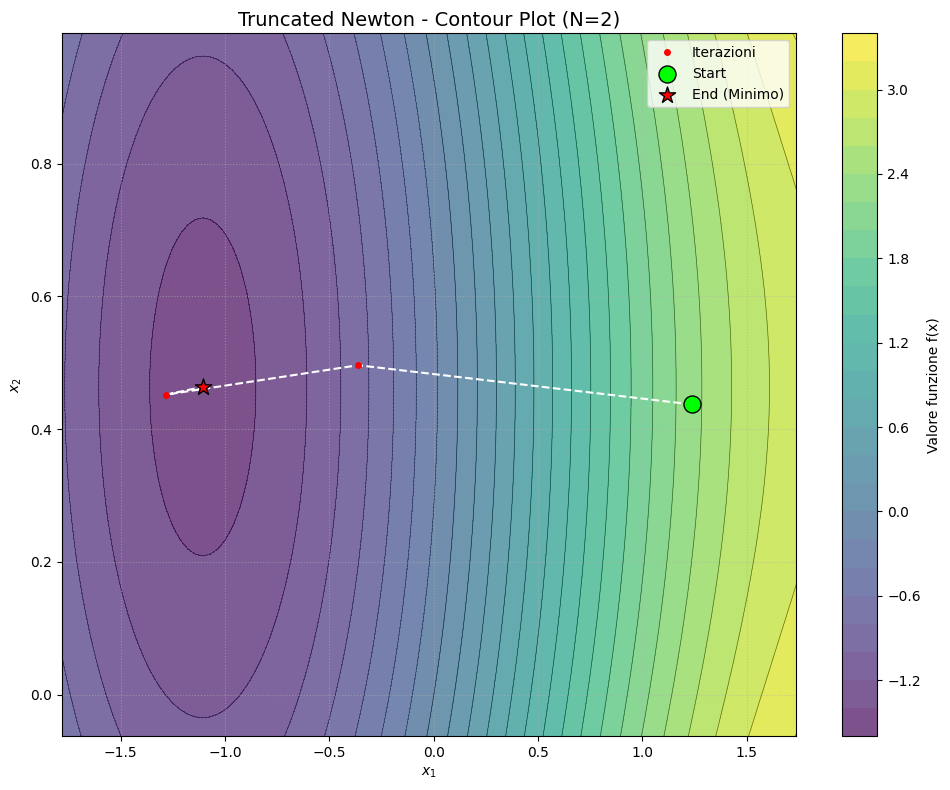

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from root.banded_trig import BandedTrigonometric


# ==========================================
# 1. CONFIGURAZIONE E ESECUZIONE
# ==========================================
N = 2
np.random.seed(358616)
# Punto iniziale per N=2 (Broyden standard spesso parte da -1)
x0 = np.random.uniform(0,2,N)

print("Esecuzione Truncated Newton...")
xk, fx, gnorm, k, hist = NewtonMethods.truncated_newton(
    x0, 
    BandedTrigonometric.func, 
    BandedTrigonometric.gradient, 
    BandedTrigonometric.hessian,
    alpha0=1.0, kmax=100, tolgrad=1e-8, c1=1e-4, rho=0.5, btmax=50
)
print(f"Ottimizzazione conclusa in {k} passi.")

# ==========================================
# 2. FUNZIONE PER IL PLOT 2D
# ==========================================
def plot_optimization_2d(hist, func, title="Percorso Ottimizzazione 2D"):
    """
    Genera un contour plot (curve di livello) con il percorso dell'algoritmo.
    """
    # Estrazione coordinate dal dizionario history
    path_x = np.array([h['x'][0] for h in hist])
    path_y = np.array([h['x'][1] for h in hist])
    
    # --- CREAZIONE GRIGLIA PER LO SFONDO ---
    # Calcoliamo i limiti del grafico basandoci sul percorso fatto
    padding = 0.5
    x_min, x_max = path_x.min() - padding, path_x.max() + padding
    y_min, y_max = path_y.min() - padding, path_y.max() + padding
    
    # Creiamo una griglia fitta (100x100 punti)
    x_range = np.linspace(x_min, x_max, 100)
    y_range = np.linspace(y_min, y_max, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros_like(X)
    
    # Valutiamo la funzione su ogni punto della griglia
    # (È un po' lento in Python puro, ma per 100x100 va bene)
    print("Generazione superficie per contour plot...")
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

    # --- DISEGNO DEL GRAFICO ---
    plt.figure(figsize=(10, 8))
    
    # 1. Contour Plot (Curve di livello riempite)
    # levels=30 crea 30 fasce di colore. 'viridis' è la scala di colori.
    cp = plt.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.7)
    plt.colorbar(cp, label='Valore funzione f(x)')
    
    # Aggiungiamo anche le linee nere per evidenziare i livelli
    plt.contour(X, Y, Z, levels=30, colors='black', linewidths=0.5, alpha=0.5)

    # 2. Percorso dell'ottimizzatore
    # Linea bianca tratteggiata per vedere bene il percorso
    plt.plot(path_x, path_y, color='white', linestyle='--', linewidth=1.5, zorder=2)
    # Punti rossi sopra la linea
    plt.plot(path_x, path_y, 'ro', markersize=4, zorder=3, label='Iterazioni')

    # 3. Start e End
    plt.scatter(path_x[0], path_y[0], c='lime', s=150, edgecolors='black', marker='o', label='Start', zorder=4)
    plt.scatter(path_x[-1], path_y[-1], c='red', s=150, edgecolors='black', marker='*', label='End (Minimo)', zorder=4)

    # Cosmetica
    plt.title(title, fontsize=14)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

# ==========================================
# 3. LANCIO
# ==========================================
plot_optimization_2d(hist, BandedTrigonometric.func, title="Truncated Newton - Contour Plot (N=2)")

Setting up problem with N=100000...
Running Truncated Newton...
START: Truncated Newton Preconditioned (N=100000)
0
3
0
1
0
0
2
3
1
2
Iter 10: ||g|| = 3.45e+06, CG iters = 1
0
0
0
1
0


/var/folders/gw/h_3h_b5d74v_ds3nx7nhw4hh0000gn/T/ipykernel_38033/282307144.py:200: RuntimeWarning: divide by zero encountered in matmul
  r_dot_y = r.T @ y        # Prodotto scalare precondizionato
/var/folders/gw/h_3h_b5d74v_ds3nx7nhw4hh0000gn/T/ipykernel_38033/282307144.py:200: RuntimeWarning: overflow encountered in matmul
  r_dot_y = r.T @ y        # Prodotto scalare precondizionato
/var/folders/gw/h_3h_b5d74v_ds3nx7nhw4hh0000gn/T/ipykernel_38033/282307144.py:200: RuntimeWarning: invalid value encountered in matmul
  r_dot_y = r.T @ y        # Prodotto scalare precondizionato
/var/folders/gw/h_3h_b5d74v_ds3nx7nhw4hh0000gn/T/ipykernel_38033/282307144.py:209: RuntimeWarning: divide by zero encountered in matmul
  pBp = p.T @ Bp
/var/folders/gw/h_3h_b5d74v_ds3nx7nhw4hh0000gn/T/ipykernel_38033/282307144.py:209: RuntimeWarning: overflow encountered in matmul
  pBp = p.T @ Bp
/var/folders/gw/h_3h_b5d74v_ds3nx7nhw4hh0000gn/T/ipykernel_38033/282307144.py:209: RuntimeWarning: invalid value 

1
1
2
2
0
Iter 20: ||g|| = 1.59e+06, CG iters = 1
3
0
0
0
0
0
1
1
0
1
Iter 30: ||g|| = 7.27e+05, CG iters = 1
0
0
1
0
0
0
0
0
1
2
Iter 40: ||g|| = 2.19e+05, CG iters = 1
0
0
0
1
1
0
0
0
0
0
Iter 50: ||g|| = 5.93e-05, CG iters = 0
0
2
3
3
3
3
3
3
3
3
Iter 60: ||g|| = 3.89e-05, CG iters = 0
3
3
3
4
4
5
5
5
5
6
Iter 70: ||g|| = 3.47e-05, CG iters = 0
7
9
11
13
18
19
20
21
27
30
Iter 80: ||g|| = 3.17e-05, CG iters = 0
30
30
30
30
30
30
30
30
30
30
Iter 90: ||g|| = 3.17e-05, CG iters = 0
30
30
30
30
30
30
30
30
30
30
Iter 100: ||g|| = 3.17e-05, CG iters = 0
30
30
30
30
30
30
30
30
30
30
Iter 110: ||g|| = 3.17e-05, CG iters = 0
30
30
30
30
30
30
30
30
30
30
Iter 120: ||g|| = 3.17e-05, CG iters = 0
30
30
30
30
30
30
30
30
30
30
Iter 130: ||g|| = 3.17e-05, CG iters = 0
30
30
30
30
30
30
30
30
30
30
Iter 140: ||g|| = 3.17e-05, CG iters = 0
30
30
30
30
30
30
30
30
30
30
Iter 150: ||g|| = 3.17e-05, CG iters = 0
30
30
30
30
30
30
30
30
30
30
Iter 160: ||g|| = 3.17e-05, CG iters = 0
30
30
30
30
30


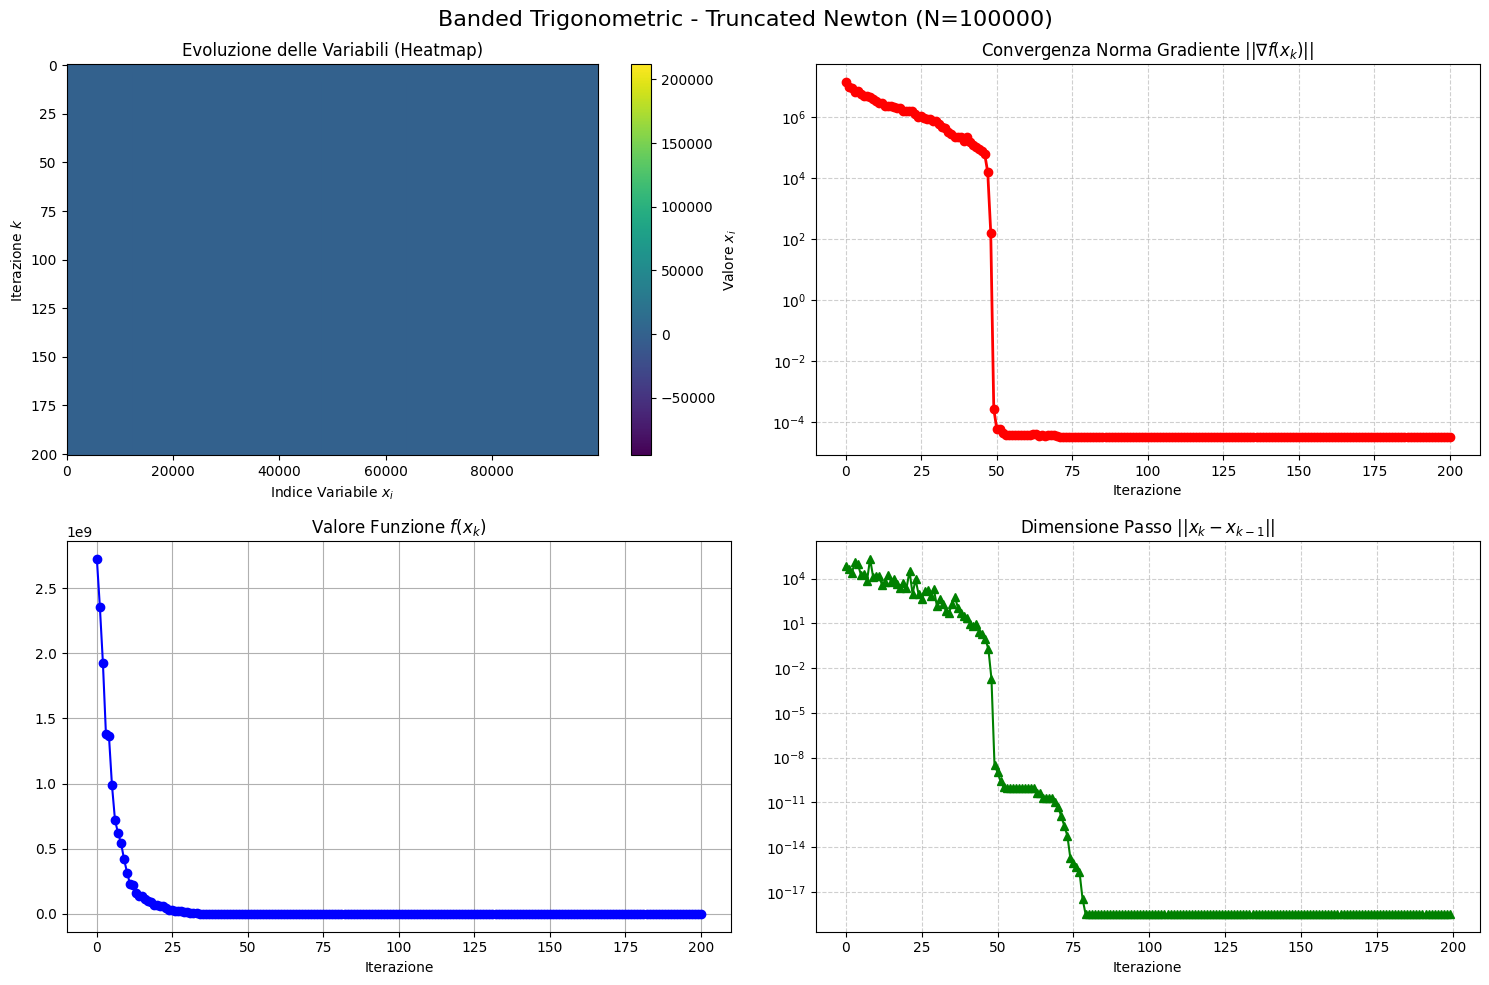

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from root.broyden import BroydenProblem
from root.banded_trig import BandedTrigonometric
#from root.methods import NewtonMethods

# ==========================================
# 1. SETUP PROBLEMA LARGE SCALE
# ==========================================
N = 100000  # Proviamo con 100 (o 1000 se vuoi)
print(f"Setting up problem with N={N}...")

# Generiamo un punto di partenza casuale ma coerente
np.random.seed(358616)
x0 = np.random.uniform(0, 2, N)

# ==========================================
# 2. ESECUZIONE (Troncato Newton)
# ==========================================
# Nota: Assicurati di usare la versione BandedTrigonometric se è quella che ti interessa
print("Running Truncated Newton...")
xk, fx, gnorm, k, hist = NewtonMethods.truncated_newton_preconditioned(
    x0, 
    BandedTrigonometric.func,     # O BroydenProblem.func
    BandedTrigonometric.gradient, 
    BandedTrigonometric.hessian,  # O hessian_sparse
    alpha0=1.0, kmax=200, tolgrad=1e-6, c1=1e-4, rho=0.5, btmax=50
)

# ==========================================
# 3. VISUALIZZAZIONE "HIGH DIMENSIONAL"
# ==========================================
def analyze_high_dimensional_results(hist, title="Analisi N-Dimensionale"):
    """
    Visualizza l'andamento delle variabili e del gradiente per N grandi.
    """
    # Estrazione dati
    iterations = [h['k'] for h in hist]
    f_values = [h['fx'] for h in hist]
    g_norms = [h['gnorm'] for h in hist]
    
    # Matrice storia delle x: (Iterazioni x N)
    x_matrix = np.array([h['x'] for h in hist]) 
    
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(f"{title} (N={x_matrix.shape[1]})", fontsize=16)

    # --- GRAFICO 1: Heatmap Evoluzione Variabili ---
    # Questo ti fa vedere "l'onda" di convergenza
    ax1 = fig.add_subplot(2, 2, 1)
    
    # Usiamo pcolormesh o imshow. Imshow è meglio per matrici dense.
    # Aspect='auto' è fondamentale altrimenti il grafico diventa una striscia sottile
    cax = ax1.imshow(x_matrix, aspect='auto', cmap='viridis', origin='upper', interpolation='nearest')
    
    ax1.set_title("Evoluzione delle Variabili (Heatmap)")
    ax1.set_xlabel("Indice Variabile $x_i$")
    ax1.set_ylabel("Iterazione $k$")
    fig.colorbar(cax, ax=ax1, label="Valore $x_i$")

    # --- GRAFICO 2: Norma del Gradiente (Log Scale) ---
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.semilogy(iterations, g_norms, 'r-o', linewidth=2)
    ax2.set_title("Convergenza Norma Gradiente $|| \\nabla f(x_k) ||$")
    ax2.set_xlabel("Iterazione")
    ax2.grid(True, which="both", linestyle='--', alpha=0.6)

    # --- GRAFICO 3: Valore Funzione ---
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.plot(iterations, f_values, 'b-o')
    ax3.set_title("Valore Funzione $f(x_k)$")
    ax3.set_xlabel("Iterazione")
    ax3.grid(True)

    # --- GRAFICO 4: Variazione ("Step Size") delle variabili ---
    # Calcoliamo quanto si spostano le variabili ad ogni passo: ||x_{k} - x_{k-1}||
    steps = np.diff(x_matrix, axis=0) # Differenza tra righe
    step_norms = np.linalg.norm(steps, axis=1)
    
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.semilogy(step_norms, 'g-^')
    ax4.set_title("Dimensione Passo $||x_k - x_{k-1}||$")
    ax4.set_xlabel("Iterazione")
    ax4.grid(True, which="both", linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Esegui l'analisi
analyze_high_dimensional_results(hist, title="Banded Trigonometric - Truncated Newton")

--- AVVIO TRUNCATED NEWTON (N=10000) ---
1
2
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
3
6
6
7
8
10
10
13
14
15
16
19
21
23
24
24
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26


/var/folders/gw/h_3h_b5d74v_ds3nx7nhw4hh0000gn/T/ipykernel_38033/282307144.py:113: RuntimeWarning: divide by zero encountered in matmul
  dBd = d.T @ Bd
/var/folders/gw/h_3h_b5d74v_ds3nx7nhw4hh0000gn/T/ipykernel_38033/282307144.py:113: RuntimeWarning: overflow encountered in matmul
  dBd = d.T @ Bd
/var/folders/gw/h_3h_b5d74v_ds3nx7nhw4hh0000gn/T/ipykernel_38033/282307144.py:113: RuntimeWarning: invalid value encountered in matmul
  dBd = d.T @ Bd
/var/folders/gw/h_3h_b5d74v_ds3nx7nhw4hh0000gn/T/ipykernel_38033/282307144.py:116: RuntimeWarning: divide by zero encountered in matmul
  alpha_j = (r.T @ r) / dBd
/var/folders/gw/h_3h_b5d74v_ds3nx7nhw4hh0000gn/T/ipykernel_38033/282307144.py:116: RuntimeWarning: overflow encountered in matmul
  alpha_j = (r.T @ r) / dBd
/var/folders/gw/h_3h_b5d74v_ds3nx7nhw4hh0000gn/T/ipykernel_38033/282307144.py:116: RuntimeWarning: invalid value encountered in matmul
  alpha_j = (r.T @ r) / dBd
/var/folders/gw/h_3h_b5d74v_ds3nx7nhw4hh0000gn/T/ipykernel_3803

26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
Finito in 99 iterazioni e 0.33 secondi.
Norma finale: 1.1639e-06


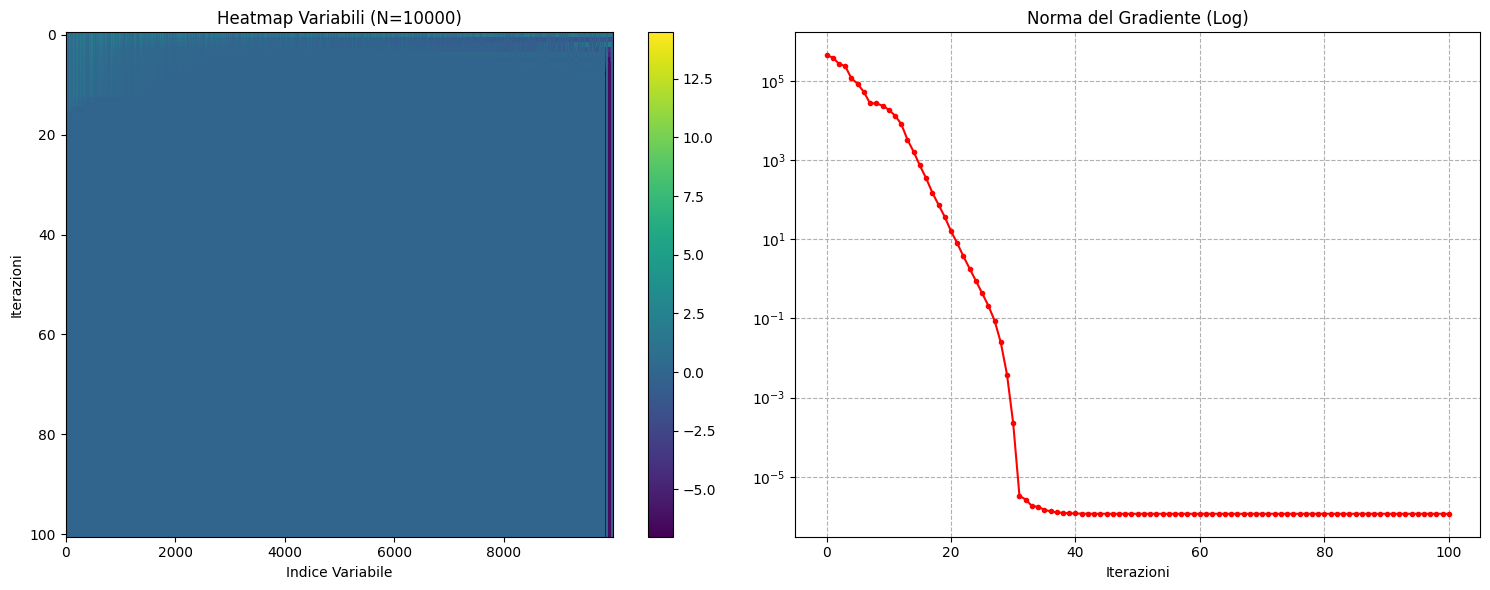

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ==========================================
# 1. DEFINIZIONE PROBLEMA (Banded Trigonometric)
# ==========================================
class BandedTrigonometric:
    @staticmethod
    def func(x):
        '''
        calcola la funzione obiettivo del Banded Tridiagonal Problem
        
        F(x) = sum(i * [(1 - cos(x_i)) + sin(x_{i-1}) - sin(x_{i+1})])
        
        x_0 = x_{n+1} = 0,

        bar(x)_i = 1, i >= 1

        Si puo semplificare algebricamente e avere:

        F(x) = sum(i * (1-cos(x_i))) + 2 * sum(sin(x_k)) - (n-1) * sin(x_n)
        '''
        x = np.asarray(x)
        n = len(x)
        
        # 1. Parte del Coseno: Dipende dall'indice 'i'
        # Formula: sum( i * (1 - cos(x_i)) )
        i_vec = np.arange(1, n + 1)
        cos_part = np.sum(i_vec * (1 - np.cos(x)))
        
        # 2. Parte dei Seni: Semplificata algebricamente
        # Formula: 2 * sum(sin(x_1...x_{n-1})) - (n-1)*sin(x_n)
        # Nota: x[:-1] prende tutti tranne l'ultimo
        sin_sum_inner = 2 * np.sum(np.sin(x[:-1])) 
        sin_last_term = - (n - 1) * np.sin(x[-1])
        
        sin_part = sin_sum_inner + sin_last_term
        
        F_x = cos_part + sin_part

        return F_x
    
    @staticmethod
    def gradient(x, h=1e-5):
        """
        Calcola il gradiente usando Differenze Finite Centrate 
        sulla versione SEMPLIFICATA algebricamente della funzione.
        Non richiede padding né accesso ai vicini.
        """
        x = np.asarray(x)
        n = len(x)
        
        # Indici [1, 2, ..., n] per il coefficiente del coseno
        ids = np.arange(1, n + 1)
        
        def get_local_contributions(val):
            """
            Calcola il vettore dei contributi locali per un dato vettore val.
            Restituisce un array di dimensione n.
            """
            # 1. Parte Coseno: k * (1 - cos(x_k))
            cos_part = ids * (1 - np.cos(val))
            
            # 2. Parte Seno: 
            #    2 * sin(x_k) per tutti
            #    -(n-1) * sin(x_n) per l'ultimo
            # 1. Creiamo un array vuoto della stessa forma di val
            sin_part = np.empty_like(val)

            # 2. Riempiamo tutti tranne l'ultimo (da 0 a n-1)
            # Calcola il seno solo per gli elementi necessari
            sin_part[:-1] = 2 * np.sin(val[:-1])

            # 3. Riempiamo l'ultimo elemento specificamente
            sin_part[-1] = -(n - 1) * np.sin(val[-1])
            
            return cos_part + sin_part

        # Calcolo Vettorizzato
        # Calcoliamo i termini perturbati (x+h) e (x-h) per tutto il vettore insieme
        terms_plus = get_local_contributions(x + h)
        terms_minus = get_local_contributions(x - h)
        
        # Differenza Centrata
        # Gradiente = (f(x+h) - f(x-h)) / 2h
        grad = (terms_plus - terms_minus) / (2 * h)
        
        return grad
    
    @staticmethod
    def hessian(x, h=1e-5):
        x = np.asarray(x)
        n = len(x)
        ids = np.arange(1, n + 1)
        
        # Coefficienti per la parte seno
        alpha = np.full(n, 2.0)
        alpha[-1] = -(n - 1)
        
        def get_local_val(val):
            # Calcola il valore "locale" della funzione per ogni componente
            # F_k = k*(1 - cos(x)) + alpha*sin(x)
            term_cos = ids * (1 - np.cos(val))
            term_sin = alpha * np.sin(val)
            return term_cos + term_sin

        # 1. Calcoliamo f(x), f(x+h), f(x-h)
        val_curr = get_local_val(x)
        val_plus = get_local_val(x + h)
        val_minus = get_local_val(x - h)
        
        # 2. Formula Differenze Finite per derivata seconda
        # (f(x+h) - 2f(x) + f(x-h)) / h^2
        h_diag = (val_plus - 2 * val_curr + val_minus) / (h ** 2)
        
        return diags(h_diag) #, 0, shape= (n,n))



# --- SE HAI GIA' IL FILE banded_trig.py CARICATO, COMMENTA LA CLASSE SOPRA E USA: ---
# from banded_trig import BandedTrigonometric

# ==========================================
# 2. FUNZIONE PLOTTING (Heatmap + Grafici)
# ==========================================
def analyze_results(hist, title="Risultati"):
    iterations = [h['k'] for h in hist]
    g_norms = [h['gnorm'] for h in hist]
    x_matrix = np.array([h['x'] for h in hist]) 
    
    fig = plt.figure(figsize=(15, 6))
    
    # Heatmap
    ax1 = fig.add_subplot(1, 2, 1)
    cax = ax1.imshow(x_matrix, aspect='auto', cmap='viridis', origin='upper', interpolation='nearest')
    ax1.set_title(f"Heatmap Variabili (N={x_matrix.shape[1]})")
    ax1.set_xlabel("Indice Variabile"); ax1.set_ylabel("Iterazioni")
    fig.colorbar(cax, ax=ax1)

    # Gradiente
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.semilogy(iterations, g_norms, 'r.-')
    ax2.set_title("Norma del Gradiente (Log)")
    ax2.set_xlabel("Iterazioni"); ax2.grid(True, linestyle='--')
    
    plt.tight_layout()
    plt.show()

# ==========================================
# 3. ESECUZIONE
# ==========================================
N = 10000
print(f"--- AVVIO TRUNCATED NEWTON (N={N}) ---")

# Setup
np.random.seed(358616)
x0 = np.random.uniform(0, 2, N)

# Esecuzione (Usa la tua classe NewtonMethods già definita nel notebook)
start = time.time()
xk, fx, gnorm, k, hist = NewtonMethods.truncated_newton(
    x0, 
    BandedTrigonometric.func, 
    BandedTrigonometric.gradient, 
    BandedTrigonometric.hessian,
    alpha0=1.0, kmax=100, tolgrad=1e-6, c1=1e-4, rho=0.5, btmax=50
)
end = time.time()

print(f"Finito in {k} iterazioni e {end-start:.2f} secondi.")
print(f"Norma finale: {gnorm:.4e}")

# Plot
analyze_results(hist, title="Banded Trigonometric Large Scale")